In [1]:
from __future__ import division
from __future__ import print_function

import argparse

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [264]:
def load(path_list):
    load_data = (lambda path: librosa.load(path)[0])
    data = list(map(load_data, path_list))
    split_data = []
    for d in data:
        split_data.append(librosa.effects.remix(d, intervals=librosa.effects.split(d)))

    return data

In [265]:
def feature_extraction(data):
    """
    wavファイルのリストから特徴抽出を行い，リストで返す
    扱う特徴量はMFCC13次元の平均（0次は含めない）
    Args:
        path_list: 特徴抽出するファイルのパスリスト
    Returns:
        features: 特徴量
    """
    features = np.array([np.mean(librosa.feature.mfcc(y=y, n_mfcc=20), axis=1) for y in data])

    return features

In [50]:
training = pd.read_csv("../../training.csv")
test = pd.read_csv("../../test.csv")

In [253]:
# 学習データの読み込み
train_data = load("../../" + training["path"].values)
test_data = load("../../" + test["path"].values)

In [266]:
train_path = training["path"].values
train_speaker = np.array([[path.split('/')[2].split('_')[0]] for path in train_path])
train_speaker[train_speaker == 'jackson'] = 0
train_speaker[train_speaker == 'nicolas'] = 1
train_speaker[train_speaker == 'theo'] = 2
train_speaker[train_speaker == 'yweweler'] = 3
train_speaker[train_speaker == 'george'] = 4
train_speaker[train_speaker == 'lucas'] = 5

In [267]:
test_path = test["path"].values
test_speaker = np.array([[path.split('/')[2].split('_')[0]] for path in test_path])
test_speaker[test_speaker == 'jackson'] = 0
test_speaker[test_speaker == 'nicolas'] = 1
test_speaker[test_speaker == 'theo'] = 2
test_speaker[test_speaker == 'yweweler'] = 3
test_speaker[test_speaker == 'george'] = 4
test_speaker[test_speaker == 'lucas'] = 5

In [268]:
# データの特徴抽出
X_train = np.concatenate([feature_extraction(train_data), train_speaker], 1)
X_test = np.concatenate([feature_extraction(test_data), test_speaker], 1)
Y_train = np.array(training["label"])

In [269]:
# 学習データを学習データとバリデーションデータに分割 (バリデーションセットを20%とした例)
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=20200616,
)

In [270]:
scaler = StandardScaler()
scaler.fit(X_train)

x_train = scaler.transform(X_train)
x_valid = scaler.transform(X_valid)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(np.array(Y_train)).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(np.array(Y_valid)).long()

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

In [271]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [416]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(21, 256)
        self.fc2 = nn.Linear(256, 500)
        # self.fc3 = nn.Linear(255, 255)
        self.fc3 = nn.Linear(500, 10)
        # self.dropout1 = nn.Dropout2d(0.2)
        # self.dropout2 = nn.Dropout2d(0.2)
        # self.dropout3 = nn.Dropout2d(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout2(x)
        # x = F.relu(self.fc3(x))
        # x = self.dropout3(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [417]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net().to(device)

In [418]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters(), lr=0.98, rho=0.96)
epochs = 100

In [419]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
 
for epoch in range(epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    net.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        acc = (outputs.max(1)[1] == labels).sum()
        train_acc += acc.item()
        loss.backward()      
        optimizer.step()
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
    
    net.eval()
    with torch.no_grad():
      for inputs, labels in valid_loader:        
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
 
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/100], Loss: 0.1209, val_loss: 0.1048, val_acc: 0.8407
Epoch [2/100], Loss: 0.1015, val_loss: 0.0999, val_acc: 0.8870
Epoch [3/100], Loss: 0.0976, val_loss: 0.0999, val_acc: 0.8833
Epoch [4/100], Loss: 0.0957, val_loss: 0.0955, val_acc: 0.9574
Epoch [5/100], Loss: 0.0952, val_loss: 0.0957, val_acc: 0.9537
Epoch [6/100], Loss: 0.0947, val_loss: 0.0955, val_acc: 0.9556
Epoch [7/100], Loss: 0.0939, val_loss: 0.0948, val_acc: 0.9630
Epoch [8/100], Loss: 0.0935, val_loss: 0.0953, val_acc: 0.9556
Epoch [9/100], Loss: 0.0932, val_loss: 0.0946, val_acc: 0.9667
Epoch [10/100], Loss: 0.0933, val_loss: 0.0951, val_acc: 0.9630
Epoch [11/100], Loss: 0.0928, val_loss: 0.0945, val_acc: 0.9611
Epoch [12/100], Loss: 0.0929, val_loss: 0.0941, val_acc: 0.9685
Epoch [13/100], Loss: 0.0925, val_loss: 0.0946, val_acc: 0.9630
Epoch [14/100], Loss: 0.0924, val_loss: 0.0945, val_acc: 0.9630
Epoch [15/100], Loss: 0.0924, val_loss: 0.0938, val_acc: 0.9722
Epoch [16/100], Loss: 0.0923, val_loss: 0.0937, v

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

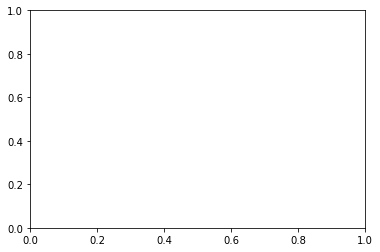

In [308]:
x = [i for i in range(1, 201)]
plt.plot(x, train_acc_list)
plt.plot(x, val_acc_list)

In [ ]:
plt.plot(x, train_loss_list)
plt.plot(x, val_loss_list)

In [125]:
x_test = scaler.transform(X_test)
x_test = torch.from_numpy(x_test).float()

In [127]:
outputs = net(x_test)

In [128]:
pred = outputs.max(1)[1]

In [130]:
pred

tensor([4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 3, 3, 3, 3,
        3, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 1, 1, 4,
        1, 1, 8, 8, 8, 8, 8, 3, 9, 9, 9, 9, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7,
        7, 7, 7, 7, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 7, 7, 7, 9, 7, 3, 3, 3, 3,
        3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 0, 0, 0,
        0, 0, 2, 2, 2, 2, 2, 6, 6, 6, 6, 2, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3,
        6, 3, 3, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 6, 6, 6, 3, 6, 7, 7, 7, 7, 7, 8,
        8, 8, 8, 8, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5,
        1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 7, 7, 7, 2, 7, 6, 6, 6, 6,
        6, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 1, 1, 1, 7, 1, 5, 5, 5, 5, 5, 8, 8, 8,
        8, 8, 0, 0, 0, 0, 0, 3, 3, 3, 3,